## Experiment description

This is the CFD Tuyere case analysis.

### Web application 5 inputs and 2 outputs

Run interactively on the web at: https://www.rcalix.com/projects/CIVSDOE/CFDtuyereSIO/index.html


### Web application 4 inputs and 2 outputs

Run interactively on the web at: https://www.rcalix.com/projects/CIVSDOE/CFDtuyereSIO4INP/index.html

Removed input: (10, 'i_ore_weight_kg')


### Inputs

(1, 'i_pul_coal_inj_kg_thm')

(2, 'i_nat_gas_inj_kg_thm')

(3, 'i_nat_gas_t_k')

(4, 'i_o2_vol_perce')

(10, 'i_ore_weight_kg')

### Outputs

(11, 'o_tuyere_exit_velo_m_s')

(12, 'o_tuyere_t_k')

### Dimensions


(44, 4).....train_X

(12, 4).....test_X

(44, 2).....train_y

(12, 2).....test_y

## Scaling

Data has been standardized. 


In [20]:
################################################
##
## regression with DL for system control
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


#######################################################

N_EPOCHS = 10000
batch_size = 5
learning_rate =  0.1    ## 0.01   ## 1e-5 

## probably need adjustable learning rate scheduler

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################

In [21]:
CFD_raw_data = pd.read_csv('CFD.6.2022.csv') 

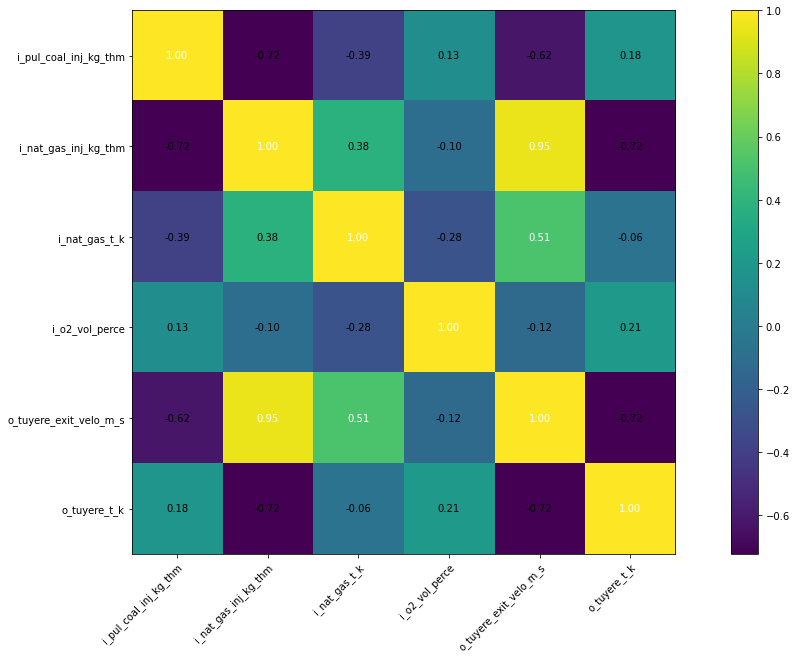

In [22]:
my_allInputs_tuyere_names = ['i_pul_coal_inj_kg_thm','i_nat_gas_inj_kg_thm','i_nat_gas_t_k','i_o2_vol_perce',
                             'o_tuyere_exit_velo_m_s','o_tuyere_t_k']



cm = np.corrcoef(CFD_raw_data[my_allInputs_tuyere_names].values.T)
hm = heatmap(cm, row_names=my_allInputs_tuyere_names, column_names=my_allInputs_tuyere_names, figsize=(20, 10))
plt.show()

In [23]:
headers_list = CFD_raw_data.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))

['index', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_bf_windrate_nm3_hr', 'i_hb_moist_g_nm3', 'i_hot_blast_press_pa', 'i_hot_blast_temp_k', 'i_coke_weight_kg', 'i_ore_weight_kg', 'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_raceway_depth _m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_cohes_zone_root_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
28
(0, 'index')
(1, 'i_pul_coal_inj_kg_thm')
(2, 'i_nat_gas_inj_kg_thm')
(3, 'i_nat_gas_t_k')
(4, 'i_o2_vol_perce')
(5, 'i_bf_windrate_nm3_hr')
(6, 'i_hb_moist_g_nm3')
(7, 'i_hot_blast_press_pa')
(8, 'i_hot_blast_temp_k')
(9, 'i_coke_weight_kg')
(10, 'i_ore_weight_kg')
(11, 'o_tuyere_exit_velo_m_s')
(12, 'o_tuyere_t_k')
(13, 'o_raceway_flame_temp_k')
(1

In [24]:
CFDdata_np = CFD_raw_data.to_numpy()
print(CFDdata_np)
print(CFDdata_np.shape)

[[ 1.          0.         37.9        ...  0.1941631   0.0438327
   0.5448123 ]
 [ 2.          0.         37.9        ...  0.2186134   0.04034286
   0.5149459 ]
 [ 3.          0.         37.9        ...  0.2353341   0.03772617
   0.4849808 ]
 ...
 [54.         70.          0.         ...  0.2279862   0.02182447
   0.5193577 ]
 [55.         70.          0.         ...  0.2387356   0.02094042
   0.4884186 ]
 [56.         70.          0.         ...  0.2464429   0.01986916
   0.4608655 ]]
(56, 28)


In [25]:
#######################################################


def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss:', loss_fn(   y_train_tr,         model(X_train_tr)                     ))
    print('Training R**2:', r2_score(  y_train_tr.numpy(), model(X_train_tr).detach().numpy()    ))
    
#######################################################

In [26]:

######################################################

'''
(1, 'i_pul_coal_inj_kg_thm')
(2, 'i_nat_gas_inj_kg_thm')
(3, 'i_nat_gas_t_k')
(4, 'i_o2_vol_perce')

'''


#######################################################

input_indeces  = [1, 2, 3, 4]
output_indeces = [11, 12 ]                            ## tuyere

#######################################################

X = CFDdata_np[:, input_indeces]

y = CFDdata_np[:, output_indeces]

print(X.shape)
print(y.shape)

#######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#######################################################

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56, 4)
(56, 2)
(44, 4)
(12, 4)
(44, 2)
(12, 2)


In [27]:
## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)

X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)

In [28]:
###################################################################
## for scaling

epsilon = 0.0001

x_means      =  X_train_tr.mean(0, keepdim=True)
x_deviations =  X_train_tr.std(0, keepdim=True) + epsilon

X_train_tr_scaled = (X_train_tr - x_means) / x_deviations
X_test_tr_scaled  = (X_test_tr  - x_means) / x_deviations



In [29]:
#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################

In [30]:
#######################################################
## Linear Regression

class LinRegNet_SI(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(4, 2) 
        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        return x

    
#############################################################


class MLP_Net_SI(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(4, 10)
        self.act1    = nn.ReLU() 
        self.linear2 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(0.25)
        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)
        
        
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x
    

#############################################################


class DL_Net_SI(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(4, 10)
        self.act1    = nn.Tanh()                         ## ReLU() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Tanh()
        self.linear3 = nn.Linear(6, 2)
        self.dropout = nn.Dropout(0.25)
        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)
        
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        x = self.linear3(x)
        
        return x

      
#############################################################

In [31]:
model = LinRegNet_SI(x_means, x_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit(N_EPOCHS, model, loss_fn, opt)

print('Test loss:', loss_fn(       model(X_test_tr),                    y_test_tr            ))
print('Testing R**2:', r2_score(   model(X_test_tr).detach().numpy(),   y_test_tr.numpy()    ))

Training loss: tensor(43.3463, grad_fn=<MseLossBackward0>)
Training R**2: 0.895627304260195
Test loss: tensor(58.1396, grad_fn=<MseLossBackward0>)
Testing R**2: 0.7783141467343292


In [32]:
model = MLP_Net_SI(x_means, x_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit(N_EPOCHS, model, loss_fn, opt)

print('Test loss:', loss_fn(       model(X_test_tr),                    y_test_tr            ))
print('Testing R**2:', r2_score(   model(X_test_tr).detach().numpy(),   y_test_tr.numpy()    ))

Training loss: tensor(99.8478, grad_fn=<MseLossBackward0>)
Training R**2: 0.7838016517920192
Test loss: tensor(131.8917, grad_fn=<MseLossBackward0>)
Testing R**2: 0.18477603185407676


In [33]:
model = DL_Net_SI(x_means, x_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit(N_EPOCHS, model, loss_fn, opt)

print('Test loss:', loss_fn(       model(X_test_tr),                    y_test_tr            ))
print('Testing R**2:', r2_score(   model(X_test_tr).detach().numpy(),   y_test_tr.numpy()    ))

Training loss: tensor(103.1168, grad_fn=<MseLossBackward0>)
Training R**2: 0.7036924923347362
Test loss: tensor(86.3030, grad_fn=<MseLossBackward0>)
Testing R**2: 0.4857243655884982


## Now scale outputs (y) as well



In [34]:
###################################################################
## for multiple regression outputs, normalize the y tensors too? 
## usually this is not done, but testing here

y_means      = y_train_tr.mean(0, keepdim=True)
y_deviations = y_train_tr.std(0,  keepdim=True) + epsilon

y_train_tr_scaled = (y_train_tr - y_means) / y_deviations
y_test_tr_scaled  = (y_test_tr - y_means) / y_deviations

####################################################################

In [35]:
#######################################################


def fit_y_scaled(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  ))
    
#######################################################

In [36]:
#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr_scaled)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################

In [50]:
#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(4, 2) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################


class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(4, 10)
        self.act1    = nn.Tanh()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(4, 10)
        self.act1    = nn.Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Tanh() 
        self.linear3 = nn.Linear(6, 2)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

      
#############################################################

In [51]:

model = LinRegNet_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.1041, grad_fn=<MseLossBackward0>)
Training R**2: 0.878559393353406
Test loss - scaled: tensor(0.1613, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(59.2386, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.7701266836483691
Testing R**2 - descaled: 0.7701263424454723


In [52]:
model = MLP_Net_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.2489, grad_fn=<MseLossBackward0>)
Training R**2: 0.7616371191902934
Test loss - scaled: tensor(0.2058, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(82.5068, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.7578910756566318
Testing R**2 - descaled: 0.757891414393371


In [54]:
model = DL_Net_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.2876, grad_fn=<MseLossBackward0>)
Training R**2: 0.6789479941335543
Test loss - scaled: tensor(0.6515, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(175.4814, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.4281829535478544
Testing R**2 - descaled: 0.4281822294264583


## Re-Run best model and generate ONNX model

In [56]:
model = LinRegNet_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.1051, grad_fn=<MseLossBackward0>)
Training R**2: 0.8757274379992832
Test loss - scaled: tensor(0.1445, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(57.2567, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.7858714356092407
Testing R**2 - descaled: 0.7858718504481366


In [57]:
for i in range(len(X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(X_test_tr[i])
    ## print(  preds_descaled.shape  )
    ## print(  preds_descaled  )
    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = y_test_tr[i].detach().numpy()
    ## print(np_pred.shape)
    ## print(np_real.shape)

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
    

**************************************************
preds, real
(130.94914, 133.4865)
(1427.9249, 1440.96)
**************************************************
preds, real
(136.08817, 133.9054)
(1443.7295, 1444.46)
**************************************************
preds, real
(152.67099, 157.34734)
(1385.9066, 1367.4567)
**************************************************
preds, real
(140.83667, 137.1573)
(1427.1719, 1428.1643)
**************************************************
preds, real
(143.79526, 140.9279)
(1416.8556, 1419.4747)
**************************************************
preds, real
(127.0213, 128.57207)
(1444.9495, 1429.0322)
**************************************************
preds, real
(127.778435, 129.75002)
(1418.5586, 1423.4567)
**************************************************
preds, real
(146.31384, 144.69981)
(1403.1628, 1406.878)
**************************************************
preds, real
(129.4023, 129.83923)
(1399.2814, 1418.1798)
*****************************

In [59]:
'''

model.eval()

dummy_input = torch.randn(1, 4)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/INP4_CFDtuyereSIO.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)

'''


'\n\nmodel.eval()\n\ndummy_input = torch.randn(1, 4)\n\n\ninput_names = ["input1"]\noutput_names = ["output1", "output2"]\n\ntorch.onnx.export(\n  model, \n  dummy_input, \n  "ONNXmodels/INP4_CFDtuyereSIO.onnx", \n  verbose=False, \n  input_names  = input_names,\n  output_names = output_names\n)\n\n'